In [1]:
import scanpy as sc
import pandas as pd

import scanpy as sc
import sys
sys.path.append("/nfs/team298/sm54/BoneAtlasProject/annotation")
from helper_functions import save_obs, restore_obs

from pathlib import Path

# Add project root to sys.path
repo_root = Path("/nfs/team298/sm54/BoneAtlasProject")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Now import
from metadata.marker_genes.marker_dict import marker_dict

from metadata.marker_genes.marker_dict import CATEGORY_MARKERS_fbm, celltypist_lymphoid,celltypist_progenitors,s_genes,g2m_genes,T_Cells,T_cell_type_genes,tcell_diff_markers

import json
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
import importlib, annotation
importlib.reload(annotation)
from annotation import (
    annotate_broad_topN,      # automatic broad annotation per cluster using marker enrichment
    extract_topN_from_rgg,    # extract top-N DEGs per cluster from scanpy rank_genes_groups
    top_genes_for_cluster,    # return DEGs for one cluster (table or list)
    attach_broad_annotations  # attach a manual/auto cluster→broad label mapping to adata.obs
)


In [2]:
panel={'Pan_Immune': 'PTPRC',
 'ERY': ['GYPA', 'HBA1', 'BLVRB', 'HBZ'],
 'PROGENITOR': ['CD34', 'SPINK2', 'PRSS57', 'MPO', 'GATA1'],
 'MK': ['ITGA2B', 'GP1BA', 'CMTM5', 'PF4'],
 'B LINEAGE': ['CD79A', 'CD19', 'DNTT', 'MME', 'VPREB1', 'RAG1', 'MS4A1'],
 'T CELL': ['CD3E', 'CD3G', 'CD7'],
 'NK': ['GZMK', 'XCL1', 'NKG7', 'PRF1'],
 'GRANULOCYTE': ['ITGAM', 'MMP9', 'ORM1', 'PGLYRP1'],
 "DC": ['CD1C', 'CD34', 'CLEC10A', 'IRF8','CADM1', 'CLEC9A', 'XCR1','FCER1A', 'HLA-DPB1',
       'S100A8','CD163'], 
 "EO/BASO": ['CLC', 'HDC', 'IL3RA', 'IL5RA'],
 'MONOCYTE': {'CD14', 'CD300E', 'IL1B', 'MS4A6A', 'S100A8'},
 'MACROPHAGE': ['APOE', 'F13A1', 'C1QC', 'SPP1'],
 'MAST': ['KIT', 'TPSAB1', 'HPGDS', 'HDC']}

In [3]:
adata_full

NameError: name 'adata_full' is not defined

#  Read in the doublet removed new annotation 

In [3]:
adata_STRINGENT_OLD_EMB= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_with_filtered_stroma_STRINGENT_DOUBLET_REMOVAL.h5ad')

In [4]:
adata_PERMISSIVE_OLD_EMB= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_with_filtered_stroma_PERMISSIVE_DOUBLET_REMOVAL.h5ad')

In [5]:
adata_str= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/best_integration_filtered_stroma_stringent_doublet_removal/processed_adata/New_Best_Integration_bone_atlas_nlatent10_nlayers3_nhidden128_nhvg3000.h5ad')

In [6]:
adata_per= sc.read_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/best_integration_with_filtered_stroma_PERMISSIVE_DOUBLET_REMOVAL//processed_adata/New_Best_Integration_bone_atlas_nlatent10_nlayers3_nhidden128_nhvg3000.h5ad')

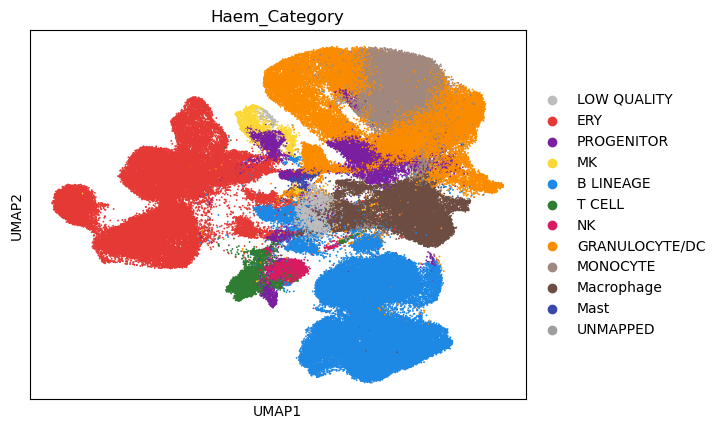

In [7]:
sc.pl.umap(adata_str, color='Haem_Category', size=7)

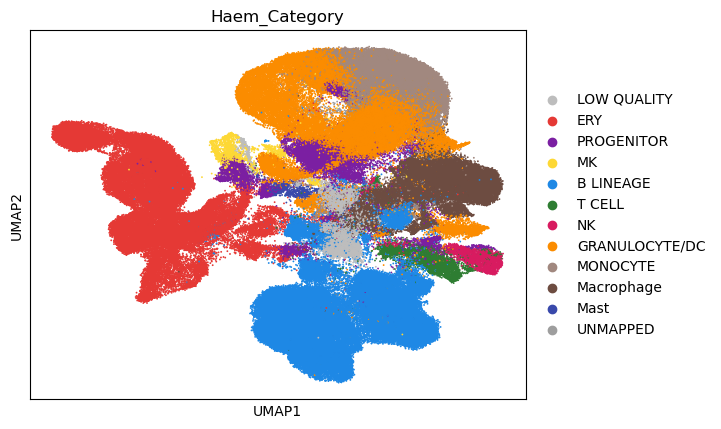

In [8]:
sc.pl.umap(adata_per, color='Haem_Category',size=7)

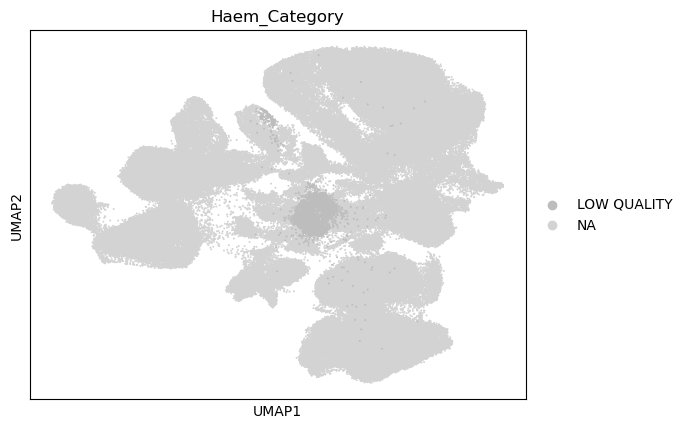

In [12]:
sc.pl.umap(adata_str, color='Haem_Category', groups='LOW QUALITY', size=8)

In [13]:
# mask = (
#     (adata_per.obs['predicted_doublets_unfiltered'] == "False") &
#     (adata_per.obs['Haem_Category'] == "LOW QUALITY")
# )

# adata_per2 = adata_per[~mask].copy()
# adata_per3 = adata_per[mask].copy()




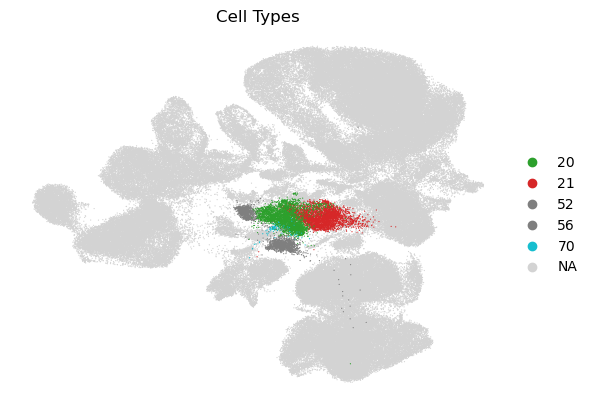

In [14]:
sc.pl.umap(
    adata_str,
    color=['leiden_res_3'],# published_anno
    size=3,   
    groups=['20','21','52','56','70'], # "promonocyte", "CD14 monocyte",'MONOCYTE_I_CXCR4',"MOP","GMP",'PROMONOCYTE',
    # Increase point size for better visibility
    legend_loc='right margin',  # Or 'right margin' if you want a separate legend
    frameon=False,
    title='Cell Types',
    palette= 'tab10'
              # High resolution
)

In [92]:
# 71 in adata_str2 is a doublet 

In [78]:
# remove clusters 20, 21 from adata_str; 52 and 56,& 70 are also low expression clusters  

In [ ]:
# Add the new embeddings,  neighbourgood uns, and obsp from adata_str to adata_STRINGENT_OLD_EMB 

In [16]:
adata_str

AnnData object with n_obs × n_vars = 188374 × 3000
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unfi

In [17]:
adata_STRINGENT_OLD_EMB

AnnData object with n_obs × n_vars = 188374 × 36601
    obs: 'barcode_raw', 'Sanger_ID', 'Cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'log1p_total_counts_rb', 'pct_counts_rb', 'total_counts_outlier', 'gene_counts_outlier', 'mt_outlier', 'Organ', '10X_Chemistry', 'Accession_ID', 'Age', 'Age(PCW)', 'Dataset', 'Donor_ID', 'FACS_Sorting', 'Anatomical_Site', 'Method', 'Multiplexed', 'Expected_Donors', 'Organism', 'Run_ID', 'Study', 'Technology', 'predicted_labels', 'over_clustering', 'majority_voting', 'predicted_labels_Level1', 'predicted_labels_Level2', 'majority_voting_Level1', 'majority_voting_Level2', 'mt_high_outlier', 'QC', 'scrublet_score_unfiltered', 'predicted_doublets_unfiltered', 'scrublet_cluster_score_unfiltered', 'bh_pval_unf

In [20]:
adata_STRINGENT_OLD_EMB.obs['leiden_res_3_old']=adata_STRINGENT_OLD_EMB.obs['leiden_res_3'].copy()

In [21]:
import numpy as np

# --- Check obs_names are identical ---
if not np.array_equal(adata_STRINGENT_OLD_EMB.obs_names, adata_str.obs_names):
    raise ValueError("Cell order mismatch between adata_STRINGENT_OLD_EMB and adata_str!")

# --- 1. Move existing keys to old_* ---
adata_STRINGENT_OLD_EMB.obsp['old_X_scVI_connectivities'] = adata_STRINGENT_OLD_EMB.obsp.pop('X_scVI_connectivities')
adata_STRINGENT_OLD_EMB.obsp['old_X_scVI_distances'] = adata_STRINGENT_OLD_EMB.obsp.pop('X_scVI_distances')
adata_STRINGENT_OLD_EMB.obsm['old_X_scVI'] = adata_STRINGENT_OLD_EMB.obsm.pop('X_scVI')
adata_STRINGENT_OLD_EMB.obsm['old_X_umap'] = adata_STRINGENT_OLD_EMB.obsm.pop('X_umap')
adata_STRINGENT_OLD_EMB.uns['old_rank_genes_groups'] = adata_STRINGENT_OLD_EMB.uns.pop('rank_genes_groups')

# --- 2. Transfer from adata_str ---
adata_STRINGENT_OLD_EMB.obsp['X_scVI_connectivities'] = adata_str.obsp['X_scVI_connectivities'].copy()
adata_STRINGENT_OLD_EMB.obsp['X_scVI_distances'] = adata_str.obsp['X_scVI_distances'].copy()
adata_STRINGENT_OLD_EMB.obsm['X_scVI'] = adata_str.obsm['X_scVI'].copy()
adata_STRINGENT_OLD_EMB.obsm['X_umap'] = adata_str.obsm['X_umap'].copy()
adata_STRINGENT_OLD_EMB.uns['rank_genes_groups'] = adata_str.uns['rank_genes_groups'].copy()

# --- 3. Transfer leiden_res_3 ---
adata_STRINGENT_OLD_EMB.obs['leiden_res_3'] = adata_str.obs['leiden_res_3'].copy()

print("✅ Old versions stored with 'old_' prefix, new data transferred from adata_str.")


✅ Old versions stored with 'old_' prefix, new data transferred from adata_str.


In [23]:
adata_STRINGENT_OLD_EMB.X.max()

8.7844095

In [24]:
adata_STRINGENT_OLD_EMB.X= adata_STRINGENT_OLD_EMB.layers['raw_counts'].copy()

In [25]:
adata_STRINGENT_OLD_EMB.X.max()

16584.0

In [26]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_STRINGENT_OLD_EMB)
# Logarithmize the data
sc.pp.log1p(adata_STRINGENT_OLD_EMB)

In [27]:
adata_STRINGENT_OLD_EMB.X.max()

8.0630245

In [28]:
adata_STRINGENT_OLD_EMB.write_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_STRINGENT_DOUBLET_REMOVAL_FULL_GENES.h5ad')

In [29]:

adata_PERMISSIVE_OLD_EMB.obs['leiden_res_3_old']=adata_PERMISSIVE_OLD_EMB.obs['leiden_res_3'].copy()




In [30]:
import numpy as np

# --- Check obs_names are identical ---
if not np.array_equal(adata_PERMISSIVE_OLD_EMB.obs_names, adata_per.obs_names):
    raise ValueError("Cell order mismatch between adata_PERMISSIVE_OLD_EMB and adata_per!")

# --- 1. Move existing keys to old_* ---
adata_PERMISSIVE_OLD_EMB.obsp['old_X_scVI_connectivities'] = adata_PERMISSIVE_OLD_EMB.obsp.pop('X_scVI_connectivities')
adata_PERMISSIVE_OLD_EMB.obsp['old_X_scVI_distances'] = adata_PERMISSIVE_OLD_EMB.obsp.pop('X_scVI_distances')
adata_PERMISSIVE_OLD_EMB.obsm['old_X_scVI'] = adata_PERMISSIVE_OLD_EMB.obsm.pop('X_scVI')
adata_PERMISSIVE_OLD_EMB.obsm['old_X_umap'] = adata_PERMISSIVE_OLD_EMB.obsm.pop('X_umap')
adata_PERMISSIVE_OLD_EMB.uns['old_rank_genes_groups'] = adata_PERMISSIVE_OLD_EMB.uns.pop('rank_genes_groups')

# --- 2. Transfer from adata_per ---
adata_PERMISSIVE_OLD_EMB.obsp['X_scVI_connectivities'] = adata_per.obsp['X_scVI_connectivities'].copy()
adata_PERMISSIVE_OLD_EMB.obsp['X_scVI_distances'] = adata_per.obsp['X_scVI_distances'].copy()
adata_PERMISSIVE_OLD_EMB.obsm['X_scVI'] = adata_per.obsm['X_scVI'].copy()
adata_PERMISSIVE_OLD_EMB.obsm['X_umap'] = adata_per.obsm['X_umap'].copy()
adata_PERMISSIVE_OLD_EMB.uns['rank_genes_groups'] = adata_per.uns['rank_genes_groups'].copy()

# --- 3. Transfer leiden_res_3 ---
adata_PERMISSIVE_OLD_EMB.obs['leiden_res_3'] = adata_per.obs['leiden_res_3'].copy()

print("✅ Old values saved with 'old_' prefix in adata_PERMISSIVE_OLD_EMB, new ones copied from adata_per.")


✅ Old values saved with 'old_' prefix in adata_PERMISSIVE_OLD_EMB, new ones copied from adata_per.


In [31]:
adata_PERMISSIVE_OLD_EMB.X= adata_PERMISSIVE_OLD_EMB.layers['raw_counts'].copy()

In [33]:
adata_PERMISSIVE_OLD_EMB.X.max()

16584.0

In [34]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_PERMISSIVE_OLD_EMB)
# Logarithmize the data
sc.pp.log1p(adata_PERMISSIVE_OLD_EMB)

In [35]:
adata_PERMISSIVE_OLD_EMB.X.max()

8.074884

In [36]:
adata_PERMISSIVE_OLD_EMB.write_h5ad('/nfs/team298/sm54/BoneAtlasProject/data/bone_haem_compartment/bone_haem_atlas_PERMISSVE_DOUBLET_REMOVAL_FULL_GENES.h5ad')